# 機械学習をPythonで実践する-6　　～ 分類器の精度指標 ～

In [97]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,LeaveOneOut, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor


%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ 混同行列
* sklearn.metrics.confusion_matrixクラスで混同行列インスタンスを生成
    * confusin_matrix(y_true, y_pred)
    * 戻り値はNumpy Array


* 混同行列(Confusion Matrix)をヒートマップで綺麗に表示する方法。
    * sklearn.metrics.ConfusionMatrixDisplay
    * ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    * confusion_matrix引数にはconfusion_matrix()の戻り値を入れる
    1. インスタンス生成
    2. .plot()メソッドで描画

In [61]:
# データ読み込み
df = sns.load_dataset('iris')
y_col = 'species'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# モデル学習。3クラスだが、デフォルトでmulti=autoなので何も指定しなくても多クラス分類してくれる。
model = LogisticRegression(penalty='none')
model.fit(X_train,y_train)

# 予測
y_pred = model.predict(X_test)

In [62]:
y_pred

array(['virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'setosa',
       'setosa', 'virginica', 'versicolor', 'setosa', 'setosa',
       'versicolor', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'setosa', 'virginica', 'versicolor', 'setosa', 'virginica',
       'virginica', 'versicolor', 'setosa', 'virginica', 'versicolor',
       'versicolor', 'virginica', 'setosa', 'virginica', 'setosa',
       'setosa'], dtype=object)

In [63]:
# 混同行列
cm = confusion_matrix(y_test, y_pred)
cm

array([[16,  0,  0],
       [ 0, 17,  1],
       [ 0,  1, 10]])

In [64]:
# クラスの順番を表示
model.classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

混同行列は縦に正解ラベルのsetosa,versicolor,virginica、横に予測値のsetosa,versicolor,virginicaとなっている。  
１行２列目の1は正解はversicolorなのに予測値がvirginicaであるという不正解が1件あったことを表す。

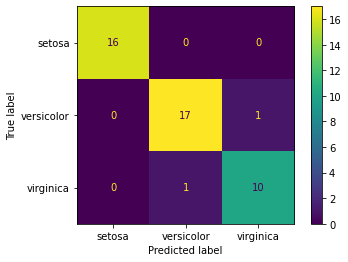

In [65]:
# 視覚的にわかりやすく混同行列を表示する。
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

## ○ Accuracy(正解率)
* sklearn.metrics.accuracy_score
    * accuracy_score(y_true, y_pred)

In [66]:
# irisデータの正解率。
accuracy_score(y_test, y_pred)

0.9555555555555556

In [67]:
# 分子は混同行列の対角成分の和になる。
(16+17+10)/(len(y_pred))

0.9555555555555556

## ○ Precision(適合率)
* sklearn.metrics.precision_score
    * precision_score(y_true, y_pred)

In [68]:
# ２値分類に使うことが多いので、サンプルデータを作る
y_true_tmp = [1, 1, 0, 1, 0, 0, 1, 1]
y_pred_tmp = [1, 1, 1, 0, 0, 1, 0, 1]

# Precisionを計算
precision_score(y_true_tmp, y_pred_tmp)

0.6

陽性(=1)と分類した中で実際に陽性である割合は60%とわかる。

## ○ Recall(再現率)
* sklearn.metrics.recall_score
    * recall_score(y_true, y_pred)

In [69]:
# recallを計算
recall_score(y_true_tmp, y_pred_tmp)

0.6

## ○ Specificity
sklearnには実装されていないが、recall_scoreを使って簡単に計算可能。  
→データの陽性と陰性を逆にしてRecallを求めればOK（元々陰性の値が陽性になるので、RecallでSpecificityに相当する値が算出できる）

In [70]:
y_true_tmp

[1, 1, 0, 1, 0, 0, 1, 1]

In [71]:
y_pred_tmp

[1, 1, 1, 0, 0, 1, 0, 1]

In [72]:
# numpy配列化して1との否定をとることで、陰性と陽性を逆にする
np.array(y_true_tmp)!=1

array([False, False,  True, False,  True,  True, False, False])

In [73]:
# 評価指標の各メソッドはbooleanの配列を入れることもできる。（Python的には0,1はbooleanと互換性があるため）
recall_score(np.array(y_true_tmp)!=1, np.array(y_pred_tmp)!=1)

0.3333333333333333

## ○ 多クラス評価におけるPrecision
* sklearn.metrics.precision_score
    * precision_score(y_true, y_pred, average)
    * average引数に’macro’, ‘micro’を渡す
    * Noneを渡すとクラス別に指標を計算しlistで返す
    * 他の指標(recall_score, accuracy_score, etc.)も同様

In [74]:
# クラスごとのPrecisionを算出
print(f'average=Noneのとき：\n{model.classes_}\n{precision_score(y_test, y_pred, average=None)}')

# macro平均を算出
print(f'average=macroのとき：{precision_score(y_test, y_pred, average="macro")}')

# micro平均を算出
print(f'average=microのとき：{precision_score(y_test, y_pred, average="micro")}')


average=Noneのとき：
['setosa' 'versicolor' 'virginica']
[1.         0.94444444 0.90909091]
average=macroのとき：0.9511784511784511
average=microのとき：0.9555555555555556


In [75]:
accuracy_score(y_test, y_pred)

0.9555555555555556

確かにPrecisionのmicro平均とAccuracyは同じになっている。

## ○ Precision-Recall Curveを描画する
* sklearn.metrics.precision_recall_curveにより描画に必要な値が取得できる。
    * precision_recall_curve(y_true, probas_pred)
    * y_trueと各データの確率値をリストにしたprobas_predを引数に渡す
    * probas_predは陽性の確率のみなので注意
    * precision, recall, thresholdsの３つの一次元NumpyArrayを返す
    * precisionとrecallの最後の要素はそれぞれ1と0であることに注意
        * それに対応するthresholdsの値は戻り値には含まれない

In [79]:
# 心臓病に関する患者データを読み込み
df = pd.read_csv('../Python/sample_data/ML_sample/heart_preprocessed.csv')

In [80]:
df.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_electrocardiographic_left ventricular hypertrophy,rest_electrocardiographic_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,52,125,212,168,1.0,2,0,1,0,0,1,1,0,0,0,0,0,0,1
1,53,140,203,155,3.1,0,0,1,0,0,1,0,0,1,1,0,1,0,1
2,70,145,174,125,2.6,0,0,1,0,0,1,1,0,0,1,0,1,0,1
3,61,148,203,161,0.0,1,0,1,0,0,1,1,0,0,0,0,0,0,1
4,62,138,294,106,1.9,3,0,0,0,0,1,0,0,0,0,1,0,1,0


心臓病に関する患者データ（Kaggleから取得したデータ）。targetは患者が心臓病を患っているかどうかを表す。  
このtargetを目的変数としてモデルを作り、Precision-Recall Curveを作成する。

In [84]:
# 目的変数と特徴量定義
y_col = 'target'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# モデル構築。標準化は割愛。ダミー変数は既にデータに含まれている。
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

In [90]:
# targetの0,1の確率を表示。1は陽性
print(model.classes_)
print(y_pred_proba[:10])

[0 1]
[[0.49520576 0.50479424]
 [0.28366806 0.71633194]
 [0.99732492 0.00267508]
 [0.06897636 0.93102364]
 [0.47851485 0.52148515]
 [0.99002332 0.00997668]
 [0.66307889 0.33692111]
 [0.79275385 0.20724615]
 [0.3021326  0.6978674 ]
 [0.3021326  0.6978674 ]]


In [91]:
y_test

993    0
859    0
298    0
553    1
672    1
      ..
167    0
998    1
984    0
491    0
10     1
Name: target, Length: 300, dtype: int64

In [94]:
# .predictで返す値は閾値50%のもの
model.predict(X_test)[:5]

array([1, 1, 0, 1, 1])

In [101]:
# precision_recall_curveの第２引数にはy_pred_probaのpositiveの確率のみ入れるので、スライシングする。
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

In [113]:
precision[:10]

array([0.48666667, 0.48993289, 0.49324324, 0.49491525, 0.49829352,
       0.5       , 0.50171821, 0.50344828, 0.50519031, 0.5087108 ])

In [114]:
recall[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [115]:
thresholds[:10]

array([0.00035687, 0.00129168, 0.00157549, 0.00174841, 0.00201324,
       0.00212929, 0.00260159, 0.00267508, 0.00312424, 0.00333926])

In [116]:
y_pred_proba[:10]

array([[0.49520576, 0.50479424],
       [0.28366806, 0.71633194],
       [0.99732492, 0.00267508],
       [0.06897636, 0.93102364],
       [0.47851485, 0.52148515],
       [0.99002332, 0.00997668],
       [0.66307889, 0.33692111],
       [0.79275385, 0.20724615],
       [0.3021326 , 0.6978674 ],
       [0.3021326 , 0.6978674 ]])

precision_recall_curveの結果はthresholdsを徐々に大きくしていった時のprecision,recallの値を返している。  
例えばindex=0であれば、thresholds=0.00035～と非常に小さい値なので、何でもかんでも陽性と判定するような閾値となっている。  
この場合、recallは最大限まで大きくなるため、1が返ってきている。その後、thresholdsが徐々に大きくなると、トレードオフの関係から  
recallが小さくなり、precisionが大きくなっていく。

Text(0.5, 1.0, 'Precision-Recall Curve')

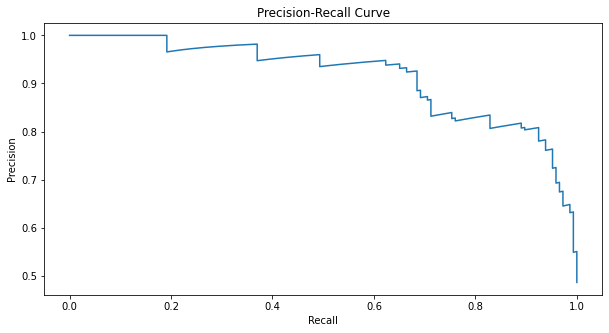

In [121]:
# precision-recall curveを描画
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')

In [123]:
recall[-1]

0.0

In [124]:
precision[-1]

1.0

In [126]:
print(len(recall))
print(len(precision))
print(len(thresholds))

210
210
209


recall,precisionの最後の値はそれぞれ0,1になっており、これらに対応するthresholdsは存在しないことに注意。

### ★Tips: JupyterLabからpip installをする場合は下記のようにセルに書いて実行
pip install --upgrade scikit-learn 　→scikit-learnをアップグレードする例 